<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/testing/multidehze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import math

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [32]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.7,validation_size=200,test_size=64,seed_val=200):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [5]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [6]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,0,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

In [7]:
class T_net(tf.keras.Model):
  def __init__(self):
    super(T_net,self).__init__()
    self.conv1=Conv2D(input_shape = (413, 550, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2=Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    
    

  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)
    conv1 = self.conv1(inputs)
    
    conv2 = self.conv2(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = self.conv3(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = self.conv4(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = self.conv5(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(K)#(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))


In [8]:


model = T_net()
model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)

#model.model().summary()
#dot_img_file = '/tmp/model_1.png'
#tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)



In [9]:
class A_net(tf.keras.Model):
  def __init__(self):
    super(A_net,self).__init__()
    self.conv1=Conv2D(input_shape = (413, 550, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2=Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    
    

  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)
    conv1 = self.conv1(inputs)
    
    conv2 = self.conv2(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = self.conv3(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = self.conv4(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = self.conv5(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(K)#(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))


In [10]:
model=A_net()
model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)


In [11]:
class Unsuper_net(tf.keras.Model):
  def __init__(self):
    super(Unsuper_net,self).__init__()
    self.t_net=T_net()
    self.a_net=A_net()

  def call(self,haze,gt=0,training=True):
    a=self.a_net(haze)
    t=self.t_net(haze)
    if training is True:
      
      j=gt
      #print(j.shape)
      #x=tf.keras.layers.Concatenate(axis=-1)([a,t,j])
      x=tf.add(tf.multiply(j,t),tf.multiply(a,(1-t)))
      return x
   
    else:
      return  tf.add(tf.math.divide_no_nan(tf.add(haze,-(a)),t),a)   

  def model(self):
        x = Input(shape = (412, 548, 3))
        y = Input(shape = (412, 548, 3))
        return Model(inputs=[x,y], outputs=self.call(x,y))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        y = Input(shape = (412, 548, 3))
        return Model(inputs=[x,y], outputs=self.call(x,y))


In [12]:
model=Unsuper_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
t_net_1 (T_net)                 (None, 412, 548, 3)  1761        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
a_net_1 (A_net)                 (None, 412, 548, 3)  1761        input_1[0][0]                    
______________________________________________________________________________________________

AttributeError: ignored

In [33]:
def custom_loss(orig,pred):
  a=tf.keras.losses.MAE(orig,pred)
  a=tf.math.reduce_mean(a,axis=None)
  b=tf.image.ssim_multiscale(orig,pred,max_val=1)
  b=tf.math.reduce_mean(b,axis=None)
  #print(a.shape)
  #print(b.shape)
  alpha=0.025
  #a=0
  #alpha=1
  return alpha*b+(1-alpha)*a

In [34]:
# Hyperparameters
epochs = 2
batch_size = 64
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = '/content/drive/MyDrive/dataset/clear_images', hazy_img_path = '/content/drive/MyDrive/dataset/haze')
#train_data, val_data = data_path()
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
#net =dehaze_net()
#
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")


8928


In [35]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    t_net=T_net()
    a_net=A_net()
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze,train_batch_orig,training=True)
                loss = custom_loss(train_batch_haze,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze,0,False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [=]  -  Training Loss: 0.2583

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


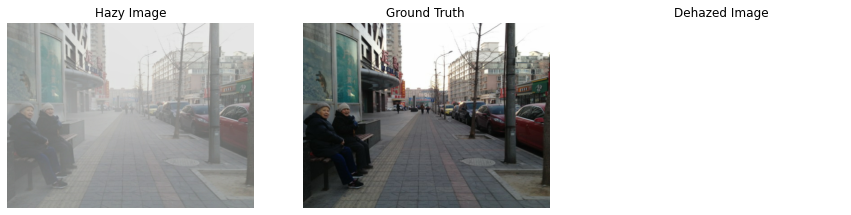

  -  Validation Loss: 537.0914  -   Time taken: 1714.98s

Start of epoch 1 [=]  -  Training Loss: 0.1139

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


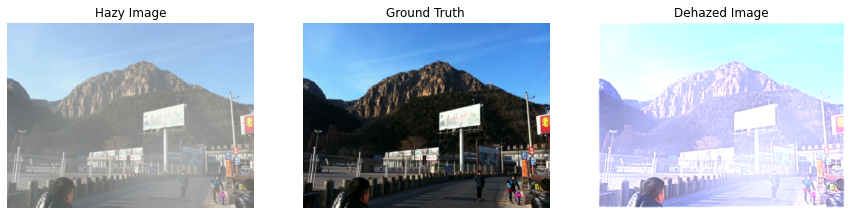

  -  Validation Loss: 0.2629  -   Time taken: 295.73s

Start of epoch 2 [=]  -  Training Loss: 0.0241

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


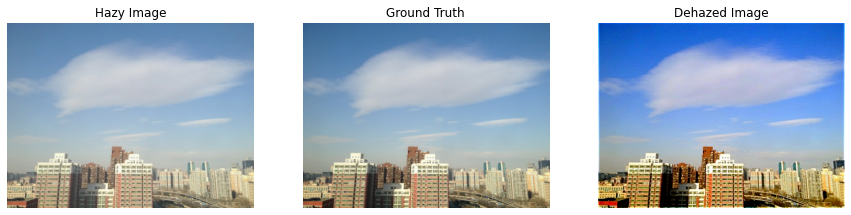

  -  Validation Loss: 0.0431  -   Time taken: 295.50s

Start of epoch 3 [=]  -  Training Loss: 0.0282

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


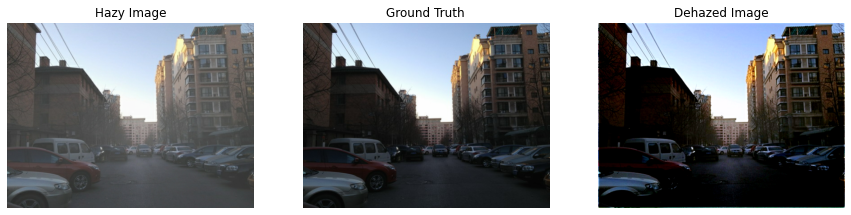

  -  Validation Loss: 0.0367  -   Time taken: 296.01s

Start of epoch 4 [=]  -  Training Loss: 0.0273

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


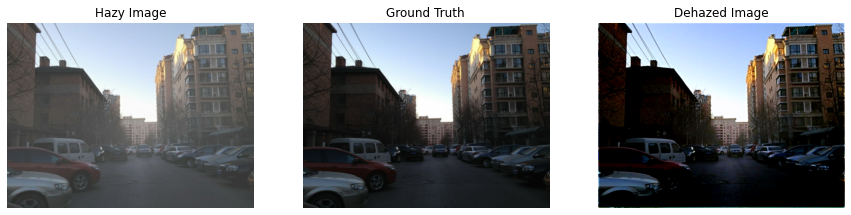

  -  Validation Loss: 0.0338  -   Time taken: 294.20s

Start of epoch 5 [=]  -  Training Loss: 0.0269

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


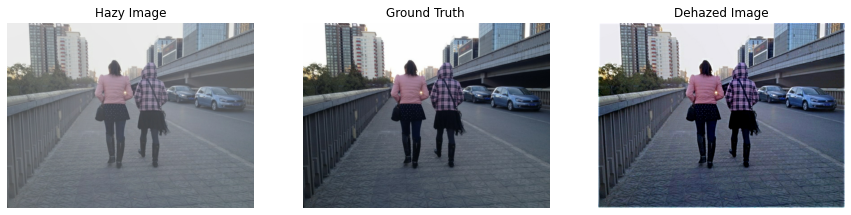

  -  Validation Loss: 0.0321  -   Time taken: 295.22s

Start of epoch 6 [=]  -  Training Loss: 0.0266

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


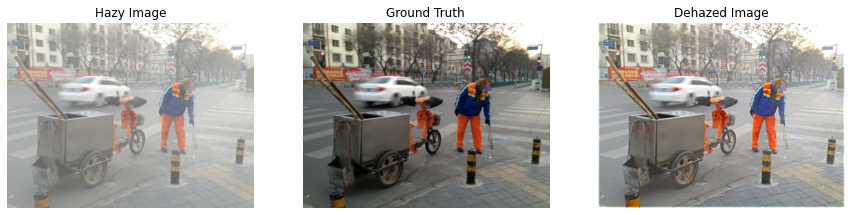

  -  Validation Loss: 0.0311  -   Time taken: 294.21s

Start of epoch 7 [=]  -  Training Loss: 0.0264

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


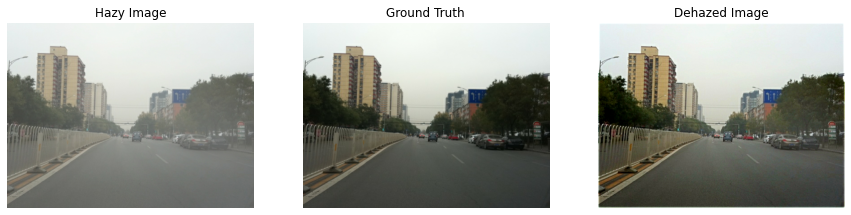

  -  Validation Loss: 0.0306  -   Time taken: 292.37s

Start of epoch 8 [=]  -  Training Loss: 0.0263

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


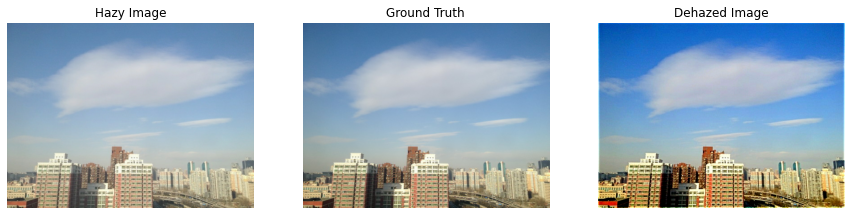

  -  Validation Loss: 0.0305  -   Time taken: 291.45s

Start of epoch 9 [=]  -  Training Loss: 0.0261

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


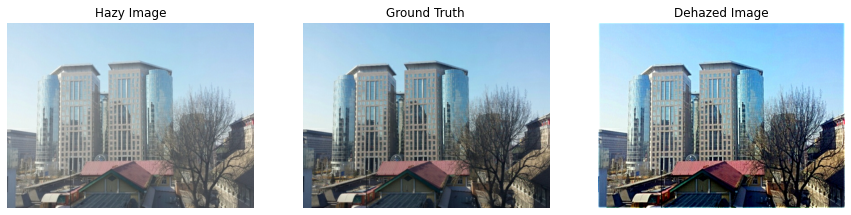

  -  Validation Loss: 0.0305  -   Time taken: 292.39s
CPU times: user 22min 35s, sys: 6min 55s, total: 29min 31s
Wall time: 1h 12min 42s


In [25]:
#checkpoint = ModelCheckpoint("/content/drive/MyDrive/Pipeline/best_model.hdf5", monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)

%%time
net=Unsuper_net()
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/multihaze',compile=False)
train_model(epochs, train, val,net,train_loss_tracker, val_loss_tracker, optimizer)

In [31]:
net.save_weights('/content/drive/MyDrive/nets/multihaze/md_weights.h5')
#model=net
#model.build([512,512,3])
#model.summary()

In [37]:
from keras.models import load_model
net1=Unsuper_net()
net1.load_weights('/content/drive/MyDrive/nets/multihaze/md_weights.h5')

ValueError: ignored

In [ ]:
train_model(epochs, train, val,net1,train_loss_tracker, val_loss_tracker, optimizer)